**Feststellung:**

Zelle 22:
Die erste Woche im Monat (1. Lauf) wird zwar nicht perfekt gesteuert, aber ist doch deutlich näher an der Realität als zum Beispiel des 2. Laufs.
Dennoch ist der Mean-Reward für den linken Trainingslauf schlechter, insbesondere konvergiert der linke Fall gar nicht!

Zelle 28:
Wenn man nun den Verlauf für das gesamte Monat ansieht, stellt man fest, dass es in der zweiten Hälfte für den 1. Lauf deutlich schlechter wird.
Es wird nur noch ein Mittelwert angenommen.
Im 2. Lauf ist es von vorn herein nur der Mittelwert, der angenommen wird.

Zelle 11:
Keine Konvergenz des Losses im 1. Lauf, im 2. Lauf vorhanden, aber noch zu wenig.

**Schlussfolgerung:**

Die Agenten tendieren dazu, den Mittelwert anzunehemn und ab und zu, wohl er zufällig, den Setpoint irgendwohin zu ändern.

**Weiteres Vorgehen:**

Stärkeres Bestrafen von höheren Temperaturabweichungen -> quadratischen Fehler (aber nur für manuelle Setpoint Eingriffe)

In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [3]:
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [5]:
fig_width = 16

In [6]:
dirnames = ["../checkpoints/s111/20210505-2121/",
            "../checkpoints/s111/20210506-1112/"
           ]

In [7]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [8]:
vh.get_arguments_overview(dirnames)

,s111,s111_2
lr,0.003,0.00011
discount_factor,0.91,0.41
reward_scale,1.0,0.5
reward_offset,0.0,0.1
agent_w_l2,4e-06,1.5e-06


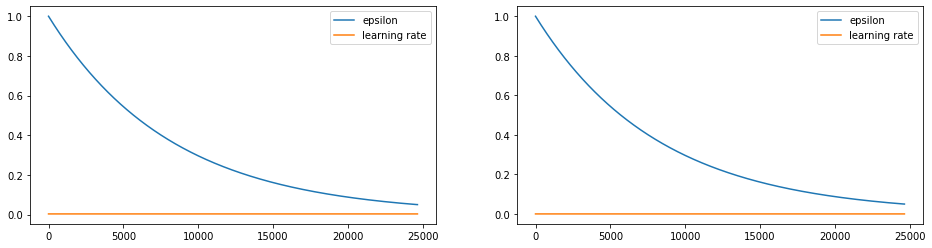

In [9]:
p, _ = vh.complete_plot_epsilon(alldfs, fig_width)
p.show()

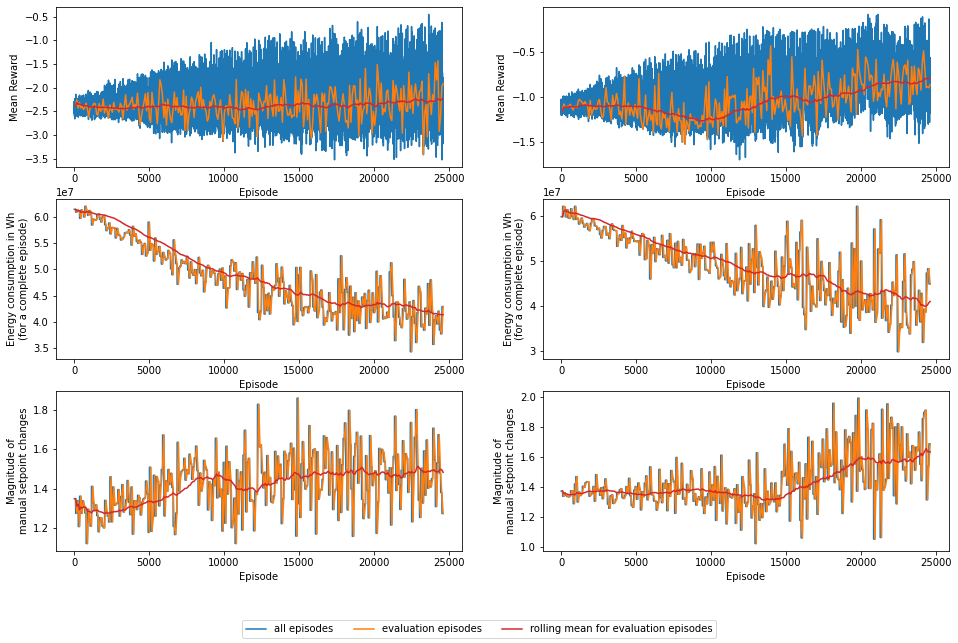

In [10]:
p, _ = vh.complete_plot_reward_stpc_econs(alldfs, fig_width)
p.show()

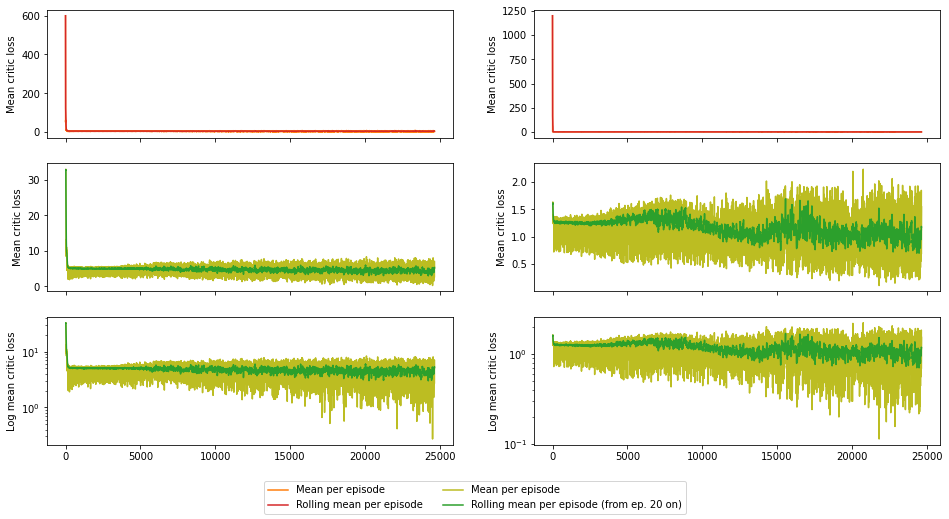

In [11]:
p, _ = vh.complete_plot_losses(alldfs, fig_width, with_agents=False)
p.show()

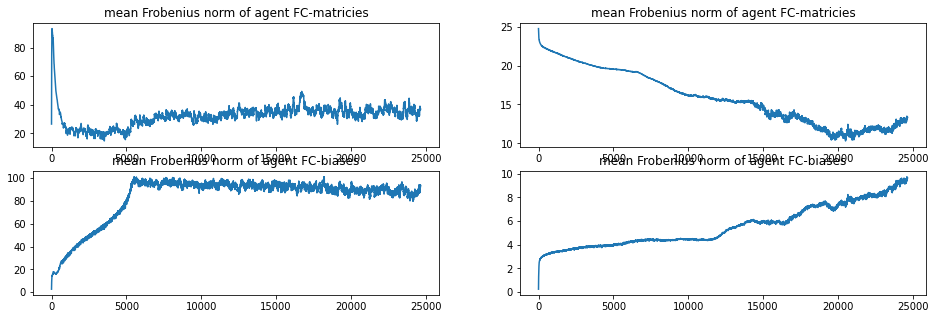

In [12]:
p, _ = vh.complete_plot_frobenius_norms(alldfs, fig_width, with_critics=False)
p.show()

In [13]:
last_available_eval_episodes = vh.compute_last_available_eval_episode(alldfs)

Last available evaluation episode for dfs0:  24639
Last available evaluation episode for dfs1:  24639


<h3>Details: Temperatur Setpoints for one week</h3>

In [14]:
#selected_episodes = [13120 - 1, 14480 - 1, 14480 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [15]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [16]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode 24639: Energy consumption:   42923.17 kWh; Numer of setpoint changes: 915.8100732025484
For episode 24639: Energy consumption:   44920.25 kWh; Numer of setpoint changes: 1213.9149350302596

Mean values for episode ...
... 24639: Reward: -1.91238 kWh; Setpoint change magnit.:  1.27373; Energy cons.: 59698.43385
... 24639: Reward: -0.85967 kWh; Setpoint change magnit.:  1.68834; Energy cons.: 62476.00561


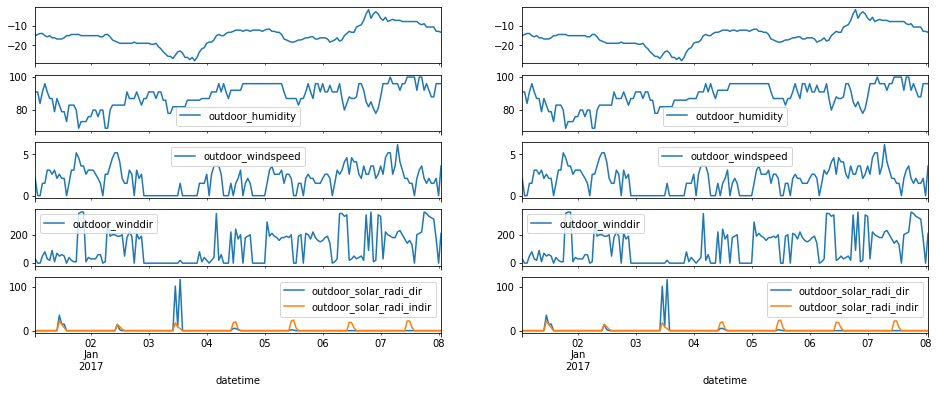

In [17]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

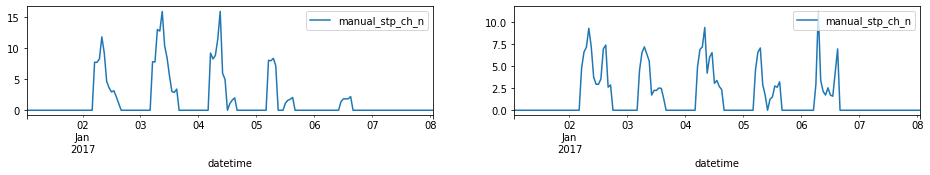

In [18]:
p, _ = vh.complete_plot_number_of_stp_ch(subdfs, fig_width)
p.show()

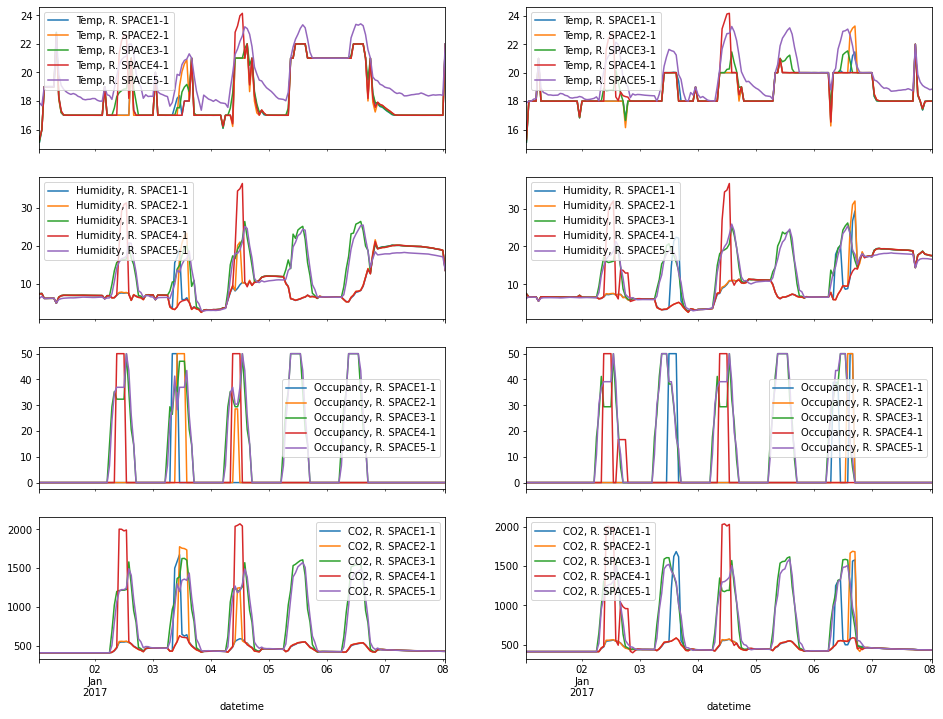

In [19]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [20]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: [0] 

Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: [0] 



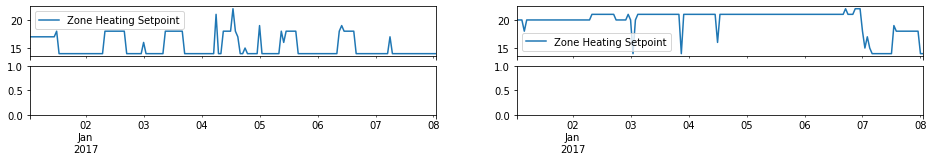

In [21]:
p, _ = vh.complete_plot_all_agent_outputs(subdfs, fig_width, subdfs_agents)
p.show()

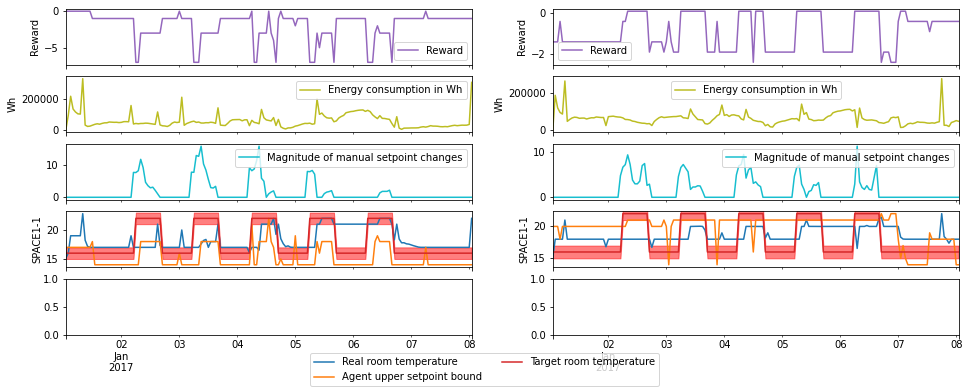

In [22]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a day</h3>

In [23]:
#selected_periods1    = [datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3)]
#selected_periods1_end= [datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4)]

In [24]:
if not "selected_periods1" in locals().keys():
    selected_periods1     = [datetime.datetime(2017, 1, 3) for _ in range(len(alldfs))]
if not "selected_periods1_end" in locals().keys():
    selected_periods1_end = [datetime.datetime(2017, 1, 4) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods1,
            selected_periods1_end)

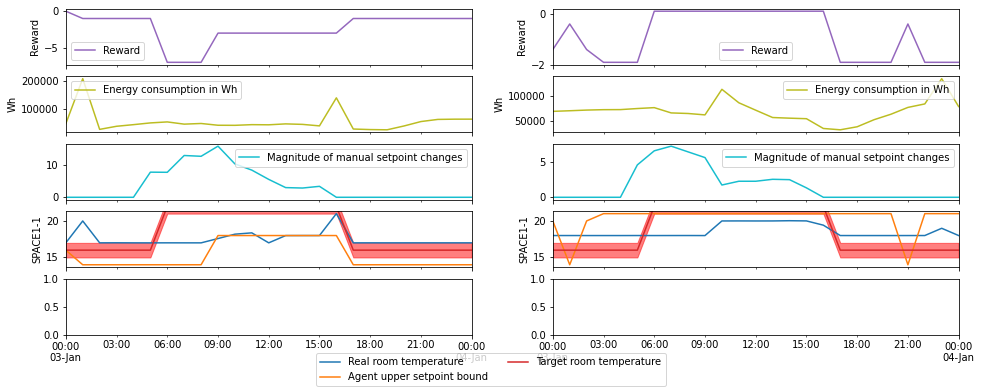

In [25]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Complete month</h3>

In [26]:
#selected_periods2    = [datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1)]

In [27]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods2,
            selected_periods2_end)

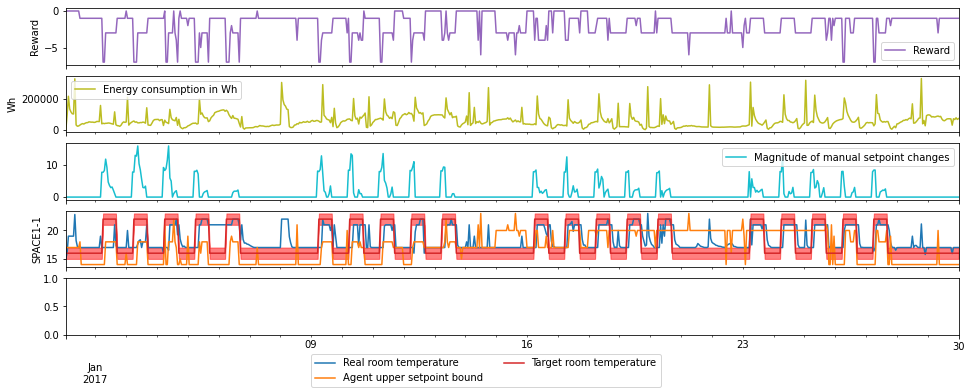

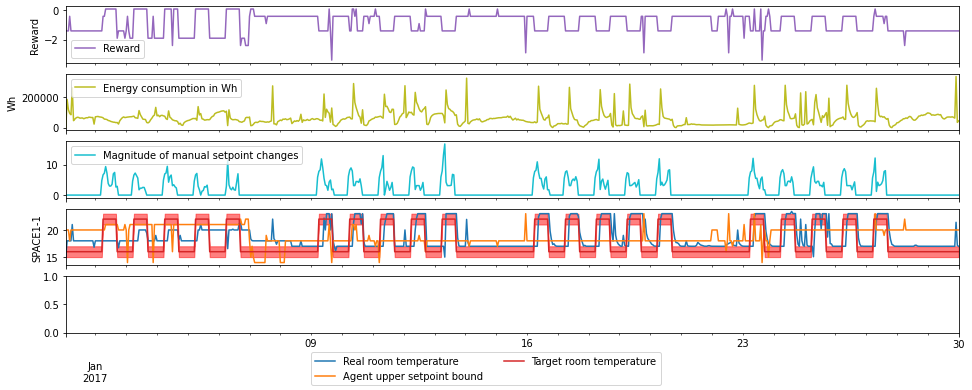

In [28]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()